# Elliptic++ Dataset: Comprehensive Exploratory Data Analysis

This notebook provides a comprehensive EDA of the Elliptic++ Bitcoin blockchain dataset, including:
- Data loading and basic statistics
- Class distribution analysis
- Temporal patterns
- Feature correlations and importance
- Network graph analysis
- Statistical distributions
- Missing value analysis

## 1. Import Libraries and Load Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# 1. Data folder
base = "Elipticpp_data"
if not os.path.isdir(base):
    raise FileNotFoundError(f"Data folder '{base}' not found. Place the extracted files there or update the path.")

# 2. Load core tables
print("Loading data files...")
txs_features = pd.read_csv(os.path.join(base, "txs_features.csv"))
txs_classes  = pd.read_csv(os.path.join(base, "txs_classes.csv"))
txs_edges    = pd.read_csv(os.path.join(base, "txs_edgelist.csv"))

wallets_features = pd.read_csv(os.path.join(base, "wallets_features.csv"))
wallets_classes  = pd.read_csv(os.path.join(base, "wallets_classes.csv"))

# 3. Merge labels
txs = txs_features.merge(txs_classes, on="txId", how="left")
wallets = wallets_features.merge(wallets_classes, on="address", how="left")

# === MAP NUMERIC CLASSES TO MEANINGFUL LABELS ===
# Elliptic++: 1 = illicit, 2 = licit, 3 = unknown
class_mapping = {
    1: "Illicit",
    2: "Licit",
    3: "Unknown"
}

txs["class_label"] = txs["class"].map(class_mapping)
wallets["class_label"] = wallets["class"].map(class_mapping)

print("\n=== Dataset Shapes ===")
print(f"Transactions: {txs.shape}")
print(f"Wallets: {wallets.shape}")
print(f"Transaction edges: {txs_edges.shape}")
print("\n✓ Data loaded successfully!")

Loading data files...

=== Dataset Shapes ===
Transactions: (203769, 186)
Wallets: (1268260, 59)
Transaction edges: (234355, 2)

✓ Data loaded successfully!

=== Dataset Shapes ===
Transactions: (203769, 186)
Wallets: (1268260, 59)
Transaction edges: (234355, 2)

✓ Data loaded successfully!


## 2. Basic Dataset Statistics

In [2]:
# Display info about datasets
print("=== TRANSACTIONS DATASET INFO ===")
print(f"Total transactions: {len(txs):,}")
print(f"Total features: {len(txs.columns)}")
print(f"Time steps covered: {txs['Time step'].min()} to {txs['Time step'].max()}")
print(f"Date range (block timestamps): {txs.shape[0]} transactions")

print("\n=== WALLETS DATASET INFO ===")
print(f"Total wallets: {len(wallets):,}")
print(f"Total features: {len(wallets.columns)}")
print(f"Time steps covered: {wallets['Time step'].min()} to {wallets['Time step'].max()}")

# Data types
print("\n=== DATA TYPES ===")
print("\nTransactions:")
print(txs.dtypes.value_counts())
print("\nWallets:")
print(wallets.dtypes.value_counts())

=== TRANSACTIONS DATASET INFO ===
Total transactions: 203,769
Total features: 186
Time steps covered: 1 to 49
Date range (block timestamps): 203769 transactions

=== WALLETS DATASET INFO ===
Total wallets: 1,268,260
Total features: 59
Time steps covered: 1 to 49

=== DATA TYPES ===

Transactions:
float64    182
int64        3
object       1
Name: count, dtype: int64

Wallets:
float64    55
object      2
int64       2
Name: count, dtype: int64


## 3. Class Distribution Analysis

=== TRANSACTION CLASS DISTRIBUTION ===
class_label
Unknown    157205
Licit       42019
Illicit      4545
Name: count, dtype: int64

Percentages:
class_label
Unknown    77.148634
Licit      20.620899
Illicit     2.230467
Name: count, dtype: float64

=== WALLET CLASS DISTRIBUTION ===
class_label
Unknown    900788
Licit      338871
Illicit     28601
Name: count, dtype: int64

Percentages:
class_label
Unknown    71.025500
Licit      26.719364
Illicit     2.255137
Name: count, dtype: float64


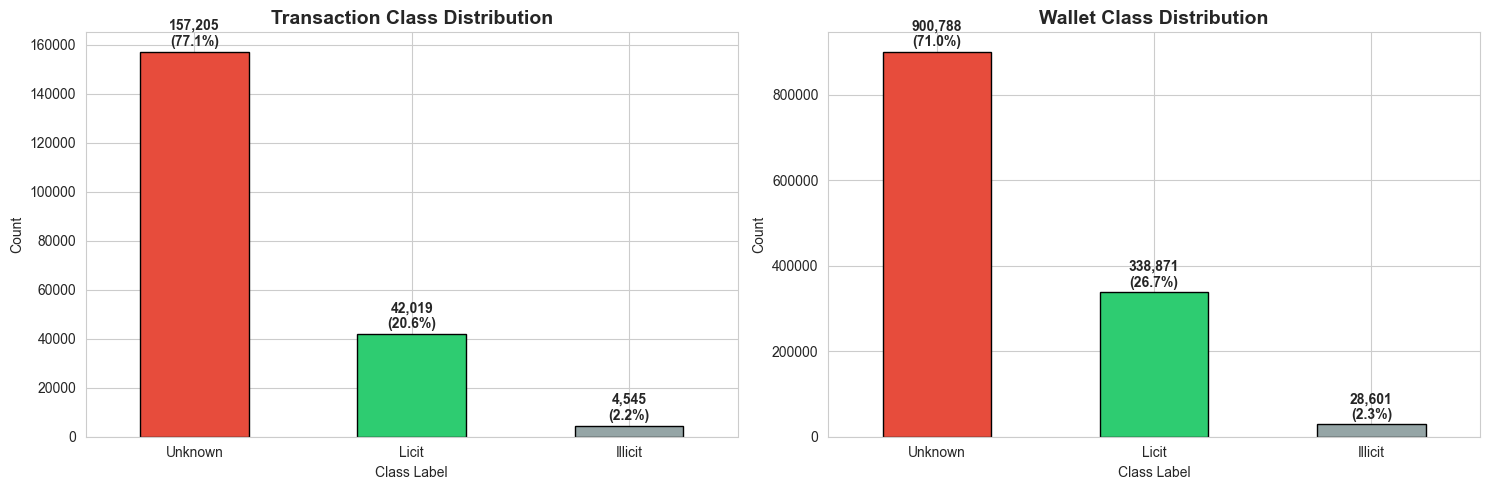


=== CLASS IMBALANCE ANALYSIS ===
Transaction - Illicit to Licit ratio: 1:9.25
Wallet - Illicit to Licit ratio: 1:11.85
Wallet - Illicit to Licit ratio: 1:11.85


In [3]:
# Class distribution (using meaningful labels)
tx_label_counts = txs["class_label"].value_counts()
wallet_label_counts = wallets["class_label"].value_counts()

print("=== TRANSACTION CLASS DISTRIBUTION ===")
print(tx_label_counts)
print(f"\nPercentages:")
print(tx_label_counts / len(txs) * 100)

print("\n=== WALLET CLASS DISTRIBUTION ===")
print(wallet_label_counts)
print(f"\nPercentages:")
print(wallet_label_counts / len(wallets) * 100)

# Visualize class distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Transactions
colors = ['#e74c3c', '#2ecc71', '#95a5a6']  # Red, Green, Gray
tx_label_counts.plot(kind="bar", ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title("Transaction Class Distribution", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
for i, v in enumerate(tx_label_counts):
    axes[0].text(i, v + 1000, f'{v:,}\n({v/len(txs)*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

# Wallets
wallet_label_counts.plot(kind="bar", ax=axes[1], color=colors, edgecolor='black')
axes[1].set_title("Wallet Class Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Class Label")
axes[1].set_ylabel("Count")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
for i, v in enumerate(wallet_label_counts):
    axes[1].text(i, v + 5000, f'{v:,}\n({v/len(wallets)*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Class imbalance ratio
print("\n=== CLASS IMBALANCE ANALYSIS ===")
print(f"Transaction - Illicit to Licit ratio: 1:{txs[txs['class_label']=='Licit'].shape[0] / txs[txs['class_label']=='Illicit'].shape[0]:.2f}")
print(f"Wallet - Illicit to Licit ratio: 1:{wallets[wallets['class_label']=='Licit'].shape[0] / wallets[wallets['class_label']=='Illicit'].shape[0]:.2f}")

## 4. Temporal Analysis

=== TIME STEP STATISTICS ===
Time steps range: 1 to 49
Total time steps: 49
Average transactions per time step: 4158.55
Median transactions per time step: 4291.00
Max transactions in a time step: 7880
Min transactions in a time step: 1089


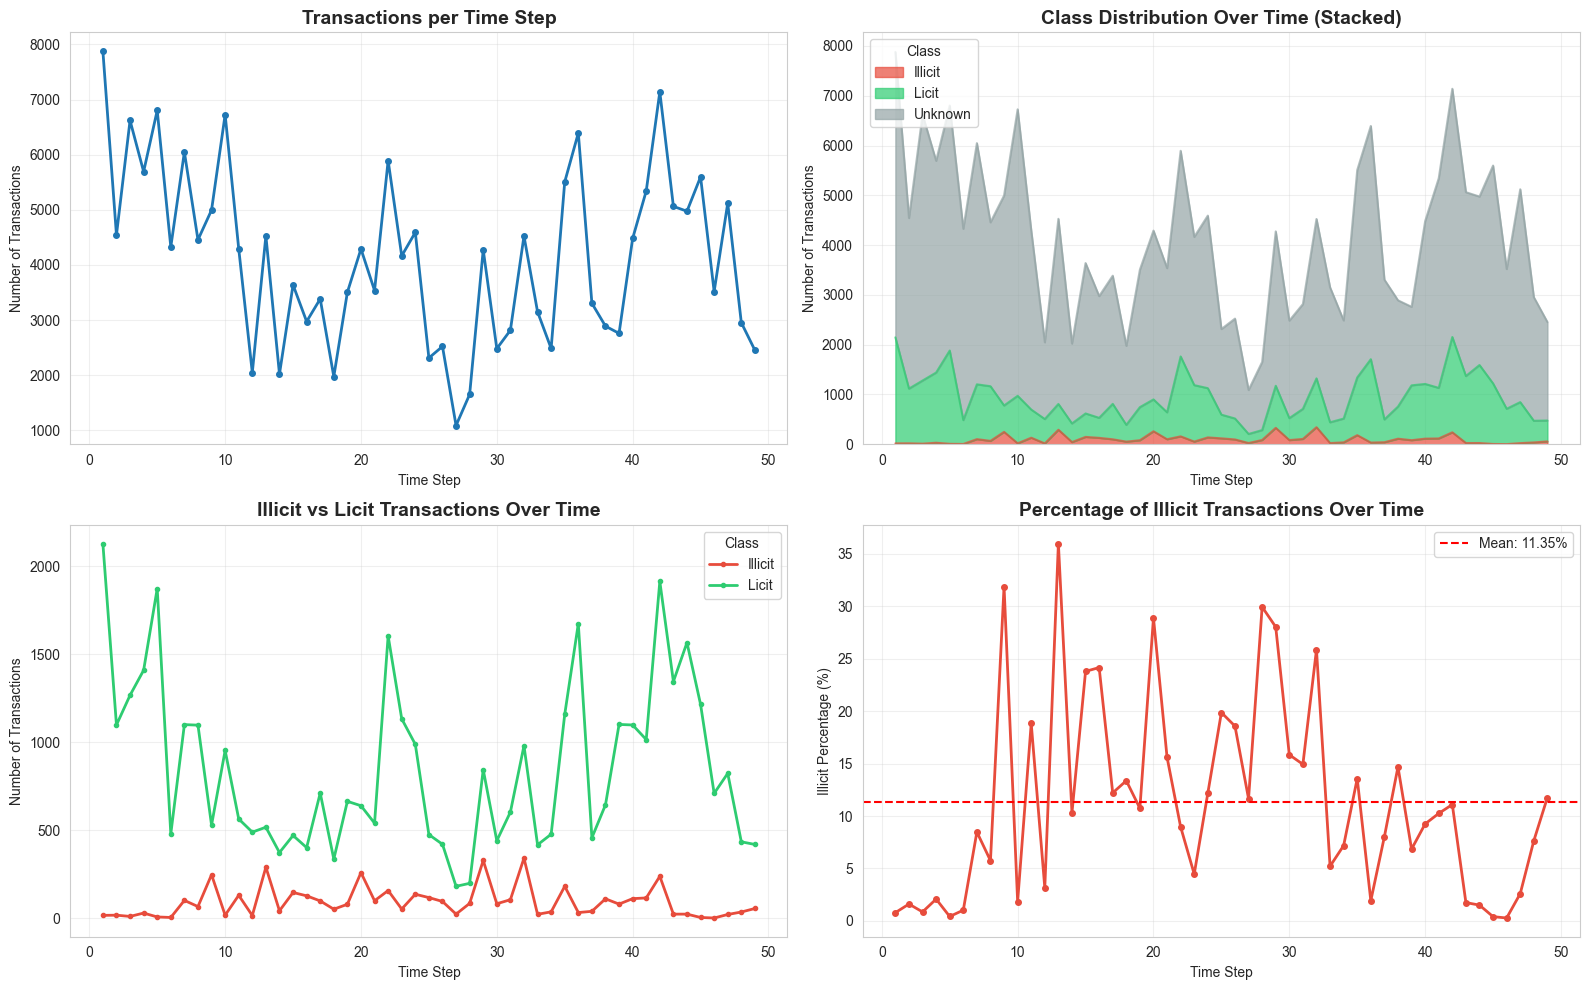

In [4]:
# Time-step distribution
timestep_counts = txs["Time step"].value_counts().sort_index()
print("=== TIME STEP STATISTICS ===")
print(f"Time steps range: {timestep_counts.index.min()} to {timestep_counts.index.max()}")
print(f"Total time steps: {len(timestep_counts)}")
print(f"Average transactions per time step: {timestep_counts.mean():.2f}")
print(f"Median transactions per time step: {timestep_counts.median():.2f}")
print(f"Max transactions in a time step: {timestep_counts.max()}")
print(f"Min transactions in a time step: {timestep_counts.min()}")

# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Overall time series
timestep_counts.plot(kind="line", marker="o", ax=axes[0, 0], linewidth=2, markersize=4)
axes[0, 0].set_title("Transactions per Time Step", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Time Step")
axes[0, 0].set_ylabel("Number of Transactions")
axes[0, 0].grid(True, alpha=0.3)

# Class distribution over time
time_class = txs.groupby(['Time step', 'class_label']).size().unstack(fill_value=0)
time_class.plot(kind='area', stacked=True, ax=axes[0, 1], 
                color=['#e74c3c', '#2ecc71', '#95a5a6'], alpha=0.7)
axes[0, 1].set_title("Class Distribution Over Time (Stacked)", fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel("Time Step")
axes[0, 1].set_ylabel("Number of Transactions")
axes[0, 1].legend(title="Class", loc='upper left')
axes[0, 1].grid(True, alpha=0.3)

# Illicit vs Licit over time (non-stacked)
time_class_filtered = time_class[['Illicit', 'Licit']]
time_class_filtered.plot(kind='line', ax=axes[1, 0], linewidth=2, 
                         color=['#e74c3c', '#2ecc71'], marker='o', markersize=3)
axes[1, 0].set_title("Illicit vs Licit Transactions Over Time", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Time Step")
axes[1, 0].set_ylabel("Number of Transactions")
axes[1, 0].legend(title="Class")
axes[1, 0].grid(True, alpha=0.3)

# Illicit percentage over time
illicit_pct = (time_class['Illicit'] / (time_class['Illicit'] + time_class['Licit']) * 100)
illicit_pct.plot(kind='line', ax=axes[1, 1], linewidth=2, color='#e74c3c', marker='o', markersize=4)
axes[1, 1].set_title("Percentage of Illicit Transactions Over Time", fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel("Time Step")
axes[1, 1].set_ylabel("Illicit Percentage (%)")
axes[1, 1].axhline(y=illicit_pct.mean(), color='r', linestyle='--', label=f'Mean: {illicit_pct.mean():.2f}%')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Missing Values Analysis

=== MISSING VALUES IN TRANSACTIONS ===
Total columns with missing values: 17

Top 20 columns with missing values:
in_BTC_mean             0.473575
in_BTC_median           0.473575
in_BTC_total            0.473575
out_BTC_min             0.473575
out_BTC_max             0.473575
out_BTC_mean            0.473575
out_BTC_median          0.473575
out_txs_degree          0.473575
in_txs_degree           0.473575
fees                    0.473575
total_BTC               0.473575
size                    0.473575
num_input_addresses     0.473575
num_output_addresses    0.473575
in_BTC_min              0.473575
in_BTC_max              0.473575
out_BTC_total           0.473575
txId                    0.000000
Local_feature_1         0.000000
Local_feature_2         0.000000
dtype: float64

=== MISSING VALUES IN WALLETS ===
Total columns with missing values: 0

Top 20 columns with missing values:
address                      0.0
Time step                    0.0
num_txs_as_sender            0.0
num

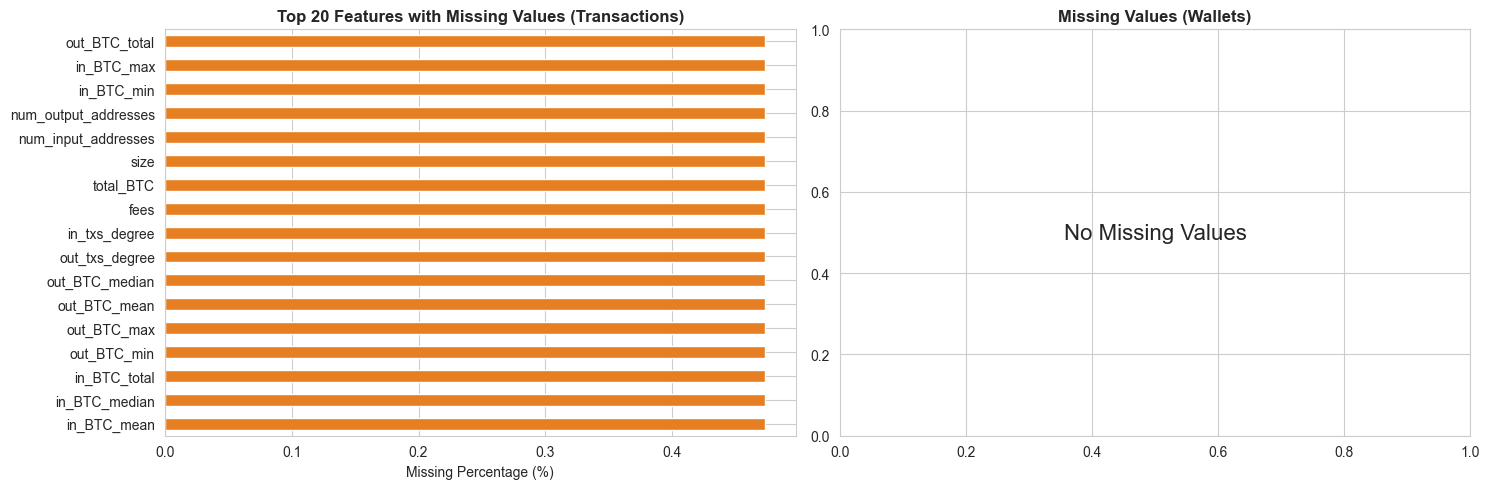

In [5]:
# Missing values analysis
print("=== MISSING VALUES IN TRANSACTIONS ===")
tx_missing = txs.isna().sum()
tx_missing_pct = (tx_missing / len(txs) * 100).sort_values(ascending=False)
print(f"Total columns with missing values: {(tx_missing > 0).sum()}")
print(f"\nTop 20 columns with missing values:")
print(tx_missing_pct.head(20))

print("\n=== MISSING VALUES IN WALLETS ===")
wallet_missing = wallets.isna().sum()
wallet_missing_pct = (wallet_missing / len(wallets) * 100).sort_values(ascending=False)
print(f"Total columns with missing values: {(wallet_missing > 0).sum()}")
print(f"\nTop 20 columns with missing values:")
print(wallet_missing_pct.head(20))

# Visualize missing values
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Transactions
if tx_missing_pct[tx_missing_pct > 0].shape[0] > 0:
    top_missing_tx = tx_missing_pct[tx_missing_pct > 0].head(20)
    top_missing_tx.plot(kind='barh', ax=axes[0], color='#e67e22')
    axes[0].set_title("Top 20 Features with Missing Values (Transactions)", 
                     fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Missing Percentage (%)")
else:
    axes[0].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=16)
    axes[0].set_title("Missing Values (Transactions)", fontsize=12, fontweight='bold')

# Wallets
if wallet_missing_pct[wallet_missing_pct > 0].shape[0] > 0:
    top_missing_wallet = wallet_missing_pct[wallet_missing_pct > 0].head(20)
    top_missing_wallet.plot(kind='barh', ax=axes[1], color='#9b59b6')
    axes[1].set_title("Top 20 Features with Missing Values (Wallets)", 
                     fontsize=12, fontweight='bold')
    axes[1].set_xlabel("Missing Percentage (%)")
else:
    axes[1].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=16)
    axes[1].set_title("Missing Values (Wallets)", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Feature Statistics and Distributions

=== TRANSACTION FEATURES OVERVIEW ===
Local features: 93
Aggregate features: 72
BTC-related features: 6

=== BTC TRANSACTION STATISTICS ===
           total_BTC           fees   in_BTC_total  out_BTC_total  \
count  202804.000000  202804.000000  202804.000000  202804.000000   
mean       27.544559       0.000813      27.545372      27.544559   
std       158.906034       0.003869     158.906122     158.906034   
min         0.000006       0.000000       0.000041       0.000006   
25%         0.072398       0.000117       0.072955       0.072398   
50%         0.606105       0.000300       0.606800       0.606105   
75%         6.590898       0.000600       6.593047       6.590898   
max     11391.855937       0.285129   11391.856516   11391.855937   

         in_BTC_mean   out_BTC_mean  
count  202804.000000  202804.000000  
mean       25.855236      11.852566  
std       155.485269      67.111277  
min         0.000014       0.000006  
25%         0.050000       0.035485  
50%       

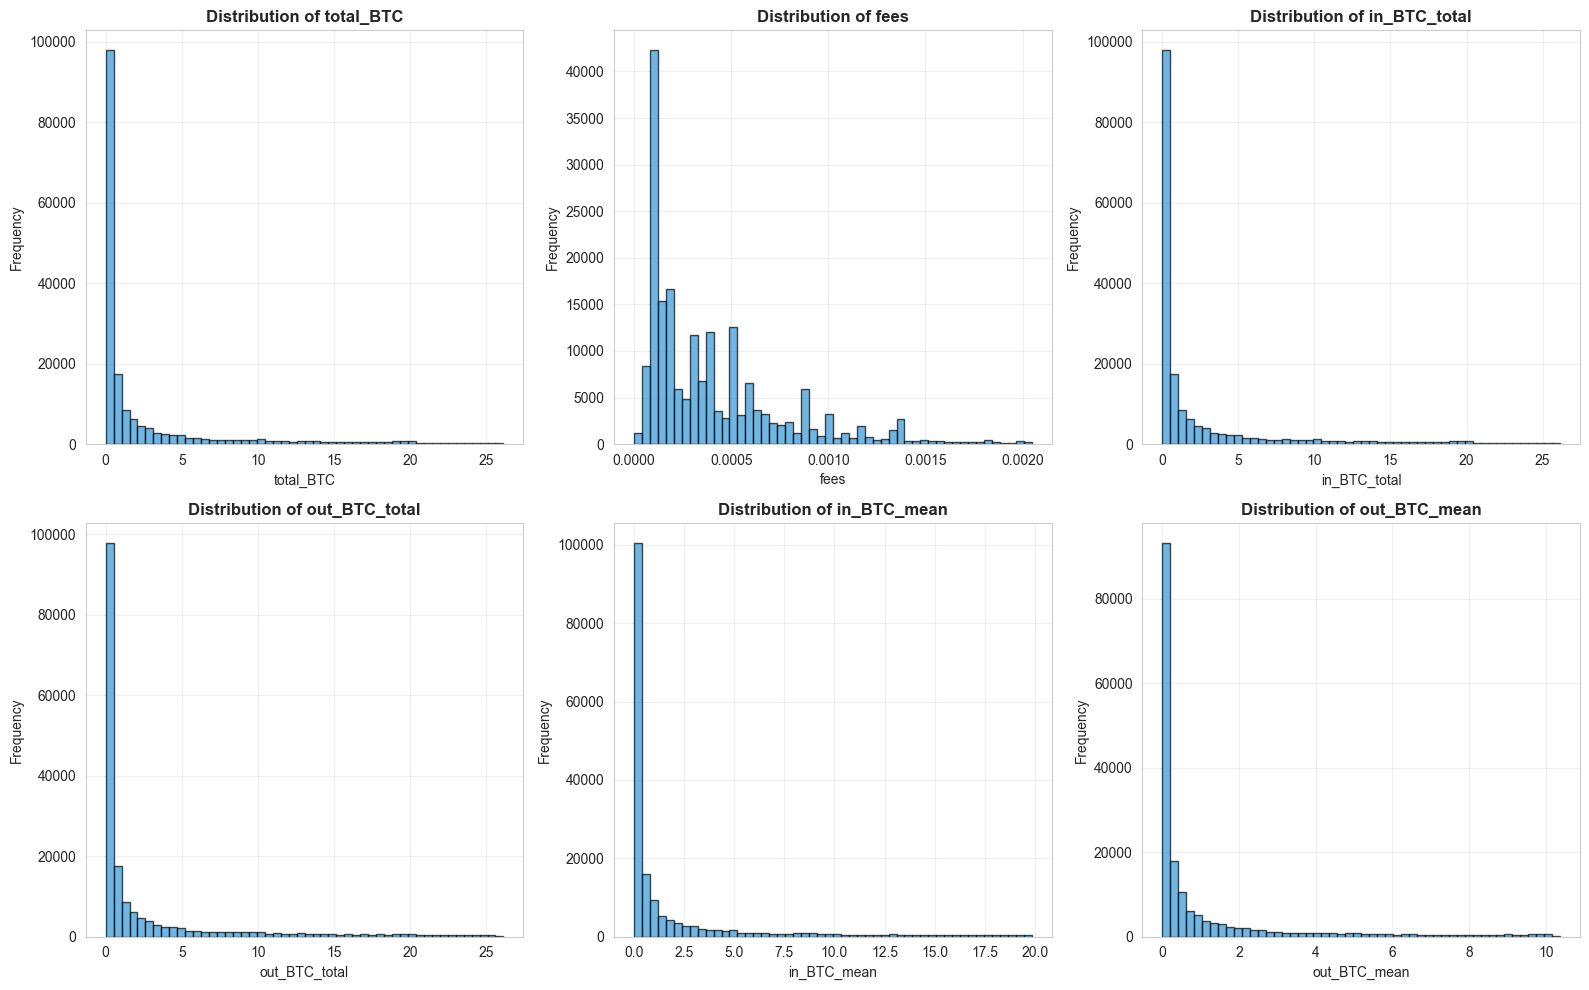


=== WALLET FEATURES OVERVIEW ===
Total numeric features in wallets: 57

=== KEY WALLET STATISTICS ===
       num_txs_as_sender  num_txs_as receiver     total_txs  \
count       1.268260e+06         1.268260e+06  1.268260e+06   
mean        1.270038e+01         6.566587e+00  1.926696e+01   
std         8.867257e+01         4.582542e+01  1.164237e+02   
min         0.000000e+00         0.000000e+00  1.000000e+00   
25%         0.000000e+00         1.000000e+00  1.000000e+00   
50%         1.000000e+00         1.000000e+00  2.000000e+00   
75%         1.000000e+00         1.000000e+00  2.000000e+00   
max         1.453000e+03         5.480000e+02  1.471000e+03   

       btc_transacted_total  btc_sent_total  btc_received_total  
count          1.268260e+06    1.268260e+06        1.268260e+06  
mean           1.481037e+02    7.610013e+01        7.200351e+01  
std            1.471962e+03    7.500943e+02        7.342121e+02  
min            0.000000e+00    0.000000e+00        0.000000e+00  

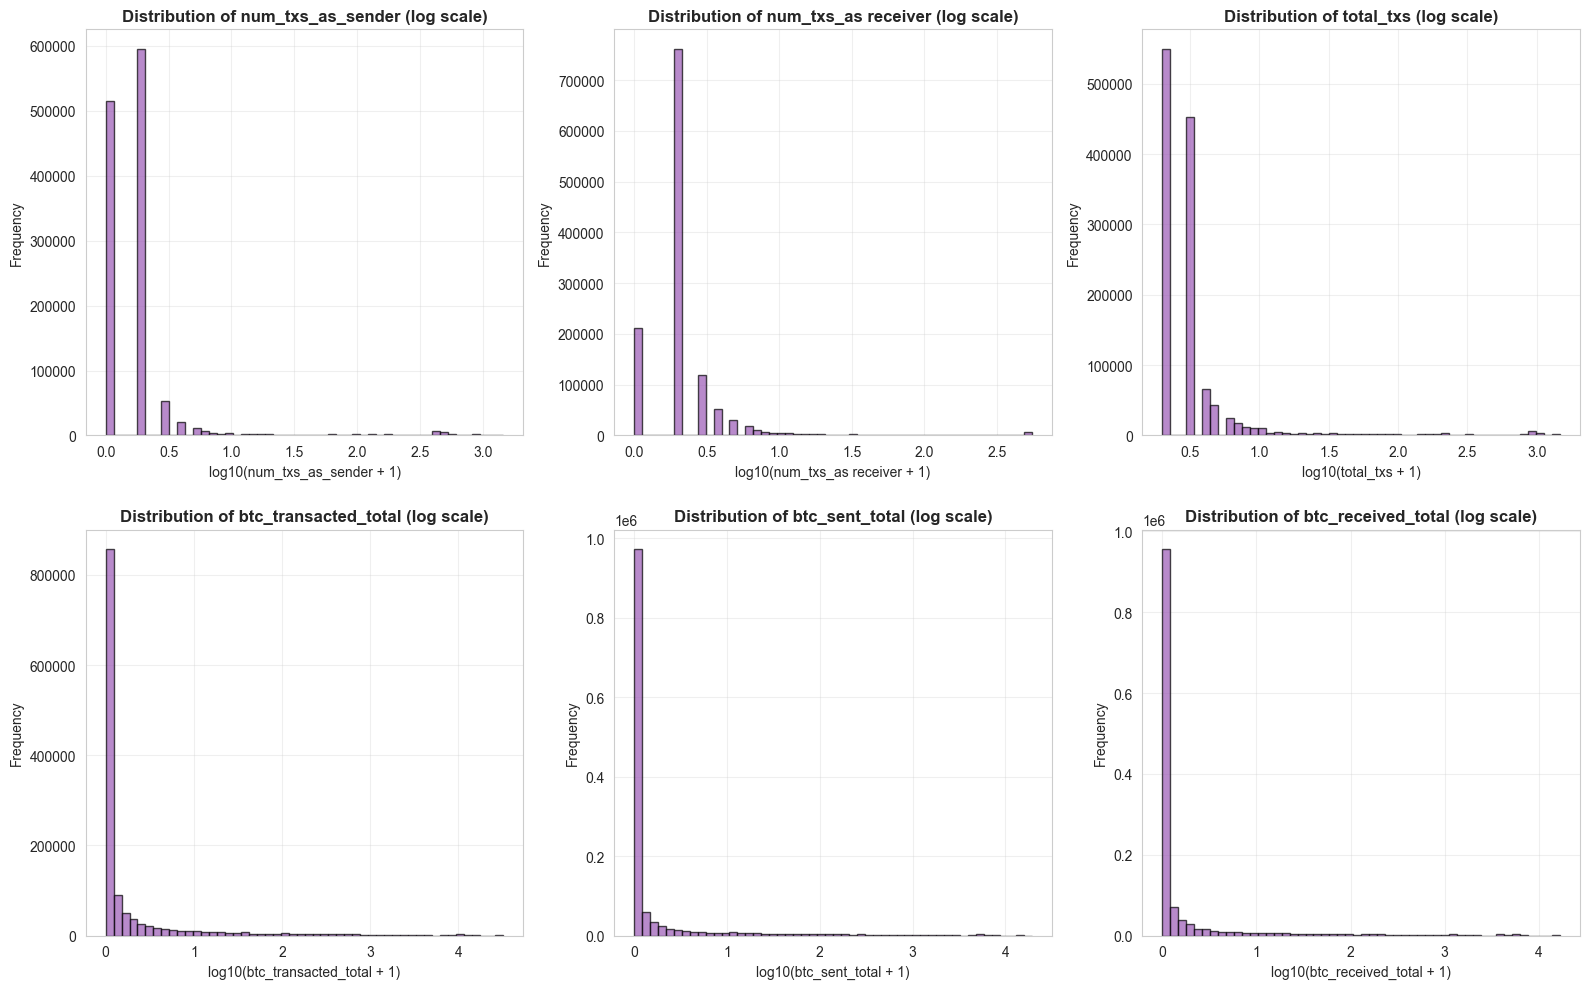

In [6]:
# Transaction feature statistics
print("=== TRANSACTION FEATURES OVERVIEW ===")
local_features = [c for c in txs.columns if c.startswith("Local_feature_")]
aggregate_features = [c for c in txs.columns if c.startswith("Aggregate_feature_")]
btc_features = ['total_BTC', 'fees', 'in_BTC_total', 'out_BTC_total', 'in_BTC_mean', 'out_BTC_mean']

print(f"Local features: {len(local_features)}")
print(f"Aggregate features: {len(aggregate_features)}")
print(f"BTC-related features: {len(btc_features)}")

print("\n=== BTC TRANSACTION STATISTICS ===")
print(txs[btc_features].describe())

# Visualize BTC distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(btc_features):
    if idx < 6:
        # Remove outliers for better visualization
        data = txs[col].dropna()
        q1, q3 = data.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower = q1 - 3 * iqr
        upper = q3 + 3 * iqr
        filtered_data = data[(data >= lower) & (data <= upper)]
        
        axes[idx].hist(filtered_data, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}', fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== WALLET FEATURES OVERVIEW ===")
wallet_numeric = wallets.select_dtypes(include=[np.number]).columns.tolist()
print(f"Total numeric features in wallets: {len(wallet_numeric)}")

# Key wallet features
key_wallet_features = ['num_txs_as_sender', 'num_txs_as receiver', 'total_txs', 
                       'btc_transacted_total', 'btc_sent_total', 'btc_received_total']
print("\n=== KEY WALLET STATISTICS ===")
print(wallets[key_wallet_features].describe())

# Visualize key wallet features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(key_wallet_features):
    data = wallets[col].dropna()
    # Log scale for better visualization
    data_log = np.log10(data + 1)
    
    axes[idx].hist(data_log, bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col} (log scale)', fontweight='bold')
    axes[idx].set_xlabel(f'log10({col} + 1)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Correlations - Transactions

=== TRANSACTION FEATURE CORRELATIONS ===


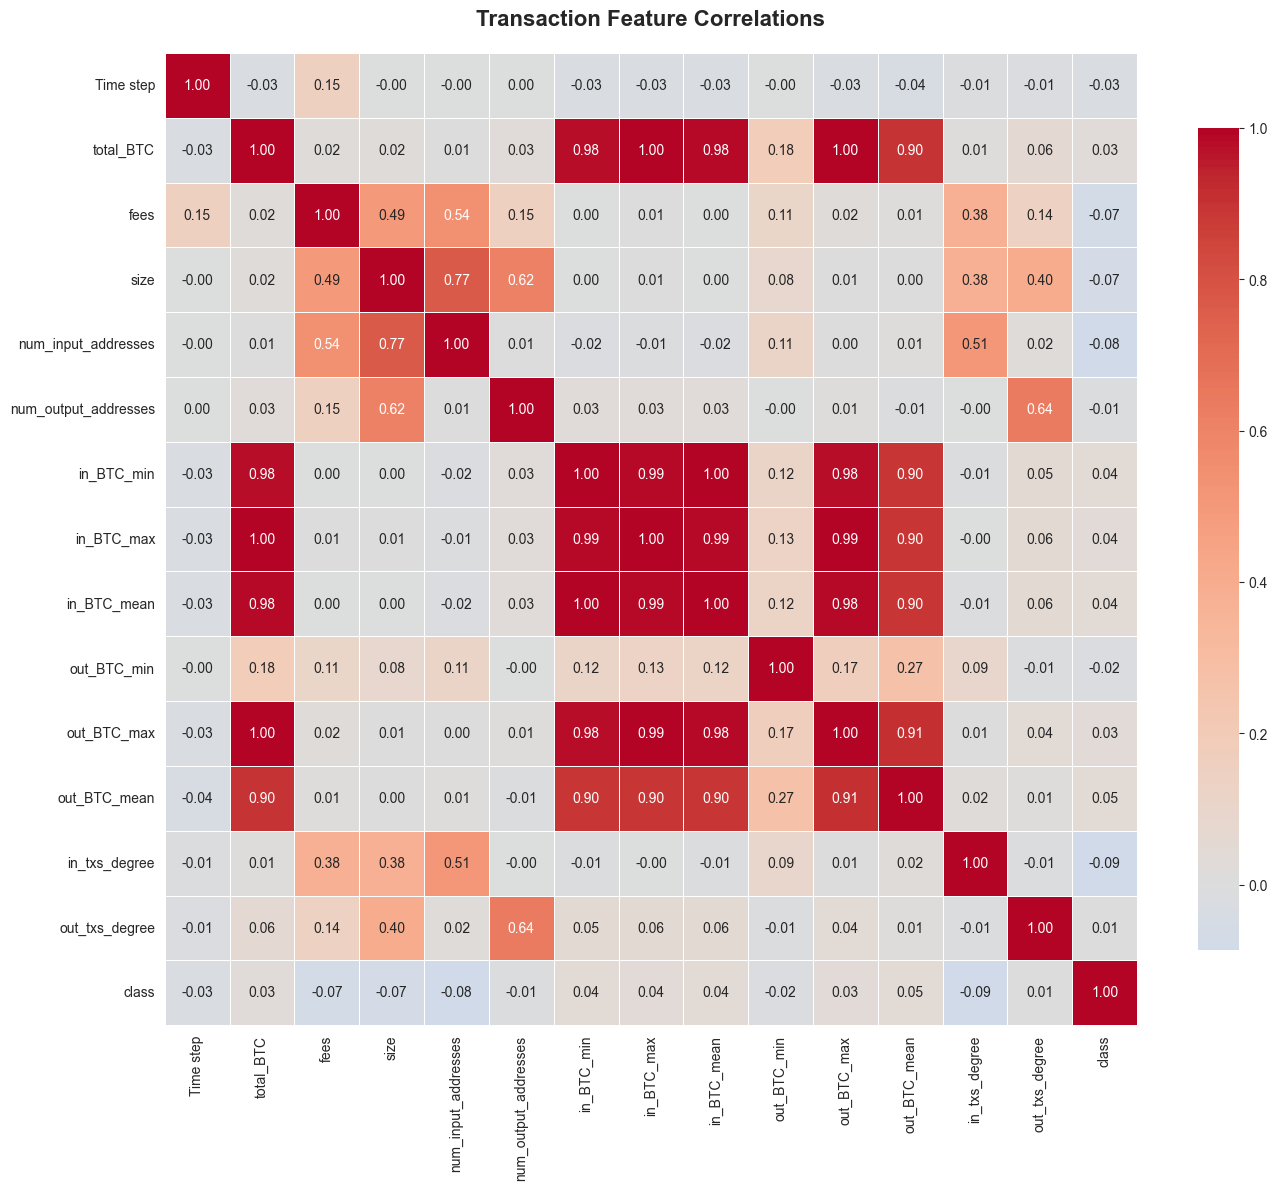


=== HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7) ===
  Feature 1           Feature 2  Correlation
 in_BTC_min         in_BTC_mean     0.998701
  total_BTC         out_BTC_max     0.996121
  total_BTC          in_BTC_max     0.995457
 in_BTC_max         out_BTC_max     0.994706
 in_BTC_max         in_BTC_mean     0.990063
 in_BTC_min          in_BTC_max     0.985136
in_BTC_mean         out_BTC_max     0.984630
  total_BTC         in_BTC_mean     0.983210
 in_BTC_min         out_BTC_max     0.979735
  total_BTC          in_BTC_min     0.977684
out_BTC_max        out_BTC_mean     0.909625
  total_BTC        out_BTC_mean     0.902009
in_BTC_mean        out_BTC_mean     0.897230
 in_BTC_max        out_BTC_mean     0.895702
 in_BTC_min        out_BTC_mean     0.895683
       size num_input_addresses     0.768092

=== FEATURES MOST CORRELATED WITH CLASS ===
in_txs_degree         -0.086431
num_input_addresses   -0.082614
fees                  -0.073990
size                  -0.067931
out_BTC_m

In [7]:
# Correlation analysis for transactions
# Focus on a subset of features for interpretability
print("=== TRANSACTION FEATURE CORRELATIONS ===")

# Select interpretable features
tx_corr_features = ['Time step', 'total_BTC', 'fees', 'size', 
                    'num_input_addresses', 'num_output_addresses',
                    'in_BTC_min', 'in_BTC_max', 'in_BTC_mean', 
                    'out_BTC_min', 'out_BTC_max', 'out_BTC_mean',
                    'in_txs_degree', 'out_txs_degree', 'class']

# Remove rows with missing values in selected features
tx_corr_data = txs[tx_corr_features].dropna()
correlation_matrix = tx_corr_data.corr()

# Heatmap of correlations
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, 
            cbar_kws={"shrink": 0.8})
plt.title("Transaction Feature Correlations", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Find highly correlated features (excluding diagonal)
print("\n=== HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7) ===")
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr:
    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', ascending=False, key=abs)
    print(high_corr_df.to_string(index=False))
else:
    print("No feature pairs with |correlation| > 0.7")

# Correlation with class label
print("\n=== FEATURES MOST CORRELATED WITH CLASS ===")
class_correlations = correlation_matrix['class'].drop('class').sort_values(key=abs, ascending=False)
print(class_correlations.head(10))

## 8. Feature Correlations - Wallets

=== WALLET FEATURE CORRELATIONS ===


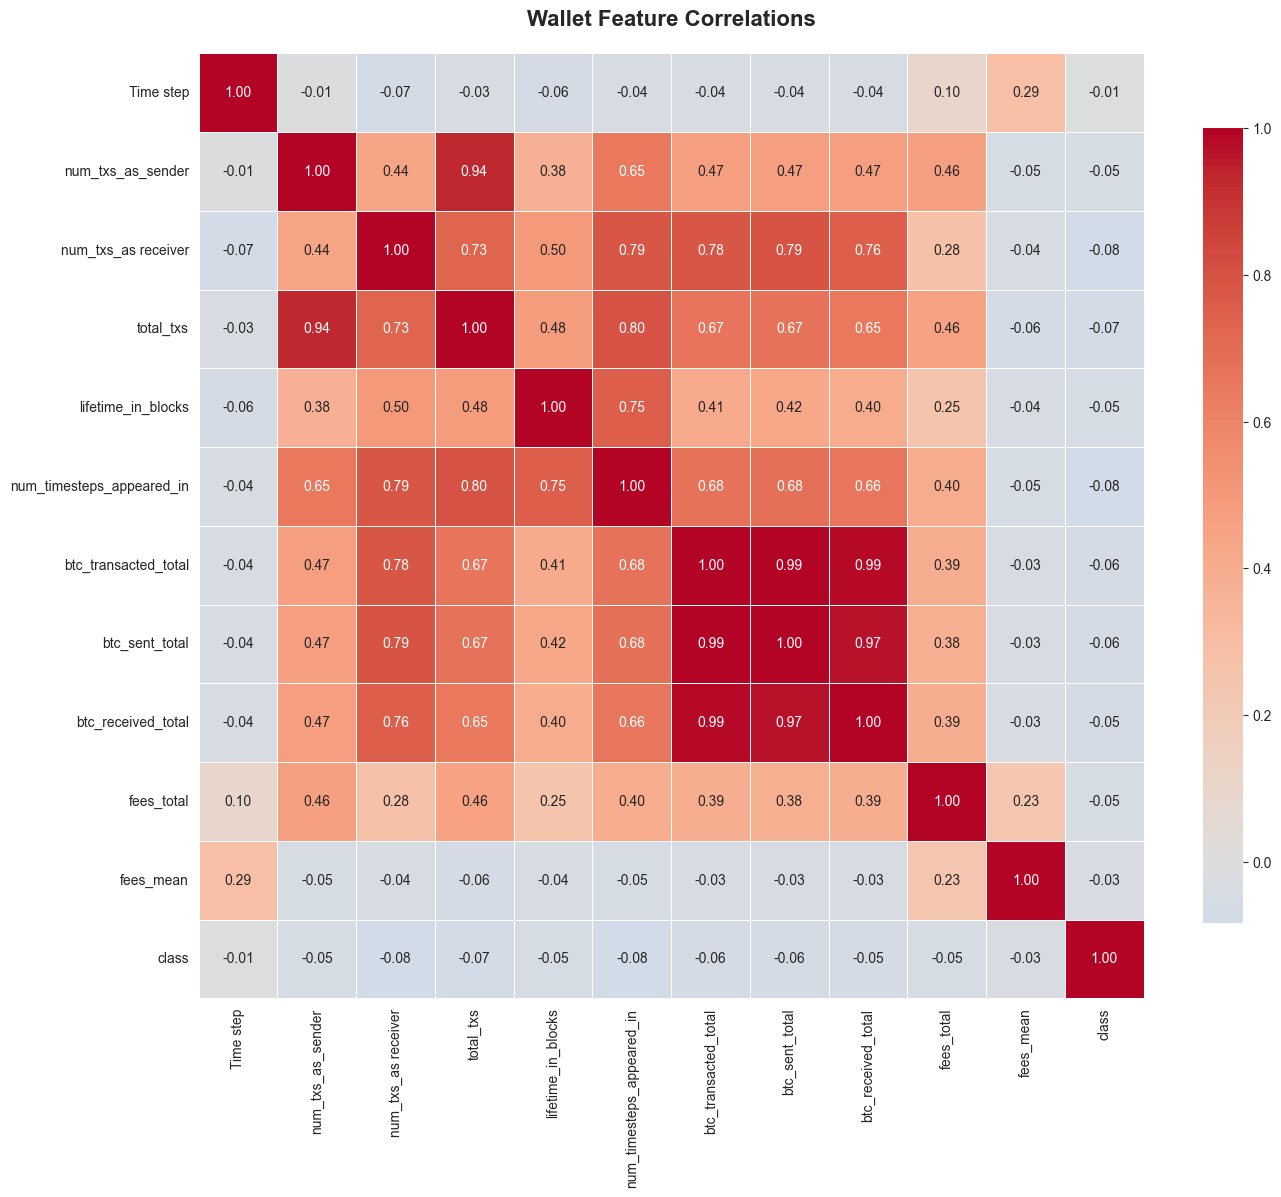


=== HIGHLY CORRELATED WALLET FEATURE PAIRS (|r| > 0.7) ===
           Feature 1                 Feature 2  Correlation
btc_transacted_total            btc_sent_total     0.991859
btc_transacted_total        btc_received_total     0.991502
      btc_sent_total        btc_received_total     0.966863
   num_txs_as_sender                 total_txs     0.935592
           total_txs num_timesteps_appeared_in     0.803809
 num_txs_as receiver            btc_sent_total     0.794601
 num_txs_as receiver num_timesteps_appeared_in     0.785710
 num_txs_as receiver      btc_transacted_total     0.782317
 num_txs_as receiver        btc_received_total     0.756613
  lifetime_in_blocks num_timesteps_appeared_in     0.753836
 num_txs_as receiver                 total_txs     0.730214

=== WALLET FEATURES MOST CORRELATED WITH CLASS ===
num_timesteps_appeared_in   -0.083741
num_txs_as receiver         -0.078349
total_txs                   -0.067528
btc_sent_total              -0.061449
btc_transacted_t

In [8]:
# Correlation analysis for wallets
print("=== WALLET FEATURE CORRELATIONS ===")

# Select key wallet features for correlation
wallet_corr_features = ['Time step', 'num_txs_as_sender', 'num_txs_as receiver', 
                        'total_txs', 'lifetime_in_blocks', 'num_timesteps_appeared_in',
                        'btc_transacted_total', 'btc_sent_total', 'btc_received_total',
                        'fees_total', 'fees_mean', 'class']

wallet_corr_data = wallets[wallet_corr_features].dropna()
wallet_correlation_matrix = wallet_corr_data.corr()

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(wallet_correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title("Wallet Feature Correlations", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Highly correlated pairs
print("\n=== HIGHLY CORRELATED WALLET FEATURE PAIRS (|r| > 0.7) ===")
high_corr_wallet = []
for i in range(len(wallet_correlation_matrix.columns)):
    for j in range(i+1, len(wallet_correlation_matrix.columns)):
        if abs(wallet_correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_wallet.append({
                'Feature 1': wallet_correlation_matrix.columns[i],
                'Feature 2': wallet_correlation_matrix.columns[j],
                'Correlation': wallet_correlation_matrix.iloc[i, j]
            })

if high_corr_wallet:
    high_corr_wallet_df = pd.DataFrame(high_corr_wallet).sort_values('Correlation', ascending=False, key=abs)
    print(high_corr_wallet_df.to_string(index=False))
else:
    print("No feature pairs with |correlation| > 0.7")

# Correlation with class
print("\n=== WALLET FEATURES MOST CORRELATED WITH CLASS ===")
wallet_class_corr = wallet_correlation_matrix['class'].drop('class').sort_values(key=abs, ascending=False)
print(wallet_class_corr.head(10))

## 9. Class-Based Feature Analysis

=== TRANSACTION FEATURES BY CLASS ===

total_BTC:
  Illicit - Mean: 1.147426, Median: 0.123366
  Licit   - Mean: 21.240166, Median: 0.481791
  Mann-Whitney U test p-value: 1.9840e-179

fees:
  Illicit - Mean: 0.000695, Median: 0.000234
  Licit   - Mean: 0.001512, Median: 0.000400
  Mann-Whitney U test p-value: 1.1929e-34

size:
  Illicit - Mean: 474.487349, Median: 192.000000
  Licit   - Mean: 1071.886675, Median: 372.000000
  Mann-Whitney U test p-value: 0.0000e+00

num_input_addresses:
  Illicit - Mean: 2.769417, Median: 1.000000
  Licit   - Mean: 5.199373, Median: 2.000000
  Mann-Whitney U test p-value: 0.0000e+00

num_output_addresses:
  Illicit - Mean: 1.352695, Median: 1.000000
  Licit   - Mean: 6.171494, Median: 2.000000
  Mann-Whitney U test p-value: 0.0000e+00

in_txs_degree:
  Illicit - Mean: 1.269967, Median: 1.000000
  Licit   - Mean: 1.924434, Median: 1.000000
  Mann-Whitney U test p-value: 1.9507e-11

out_txs_degree:
  Illicit - Mean: 0.741694, Median: 1.000000
  Licit   

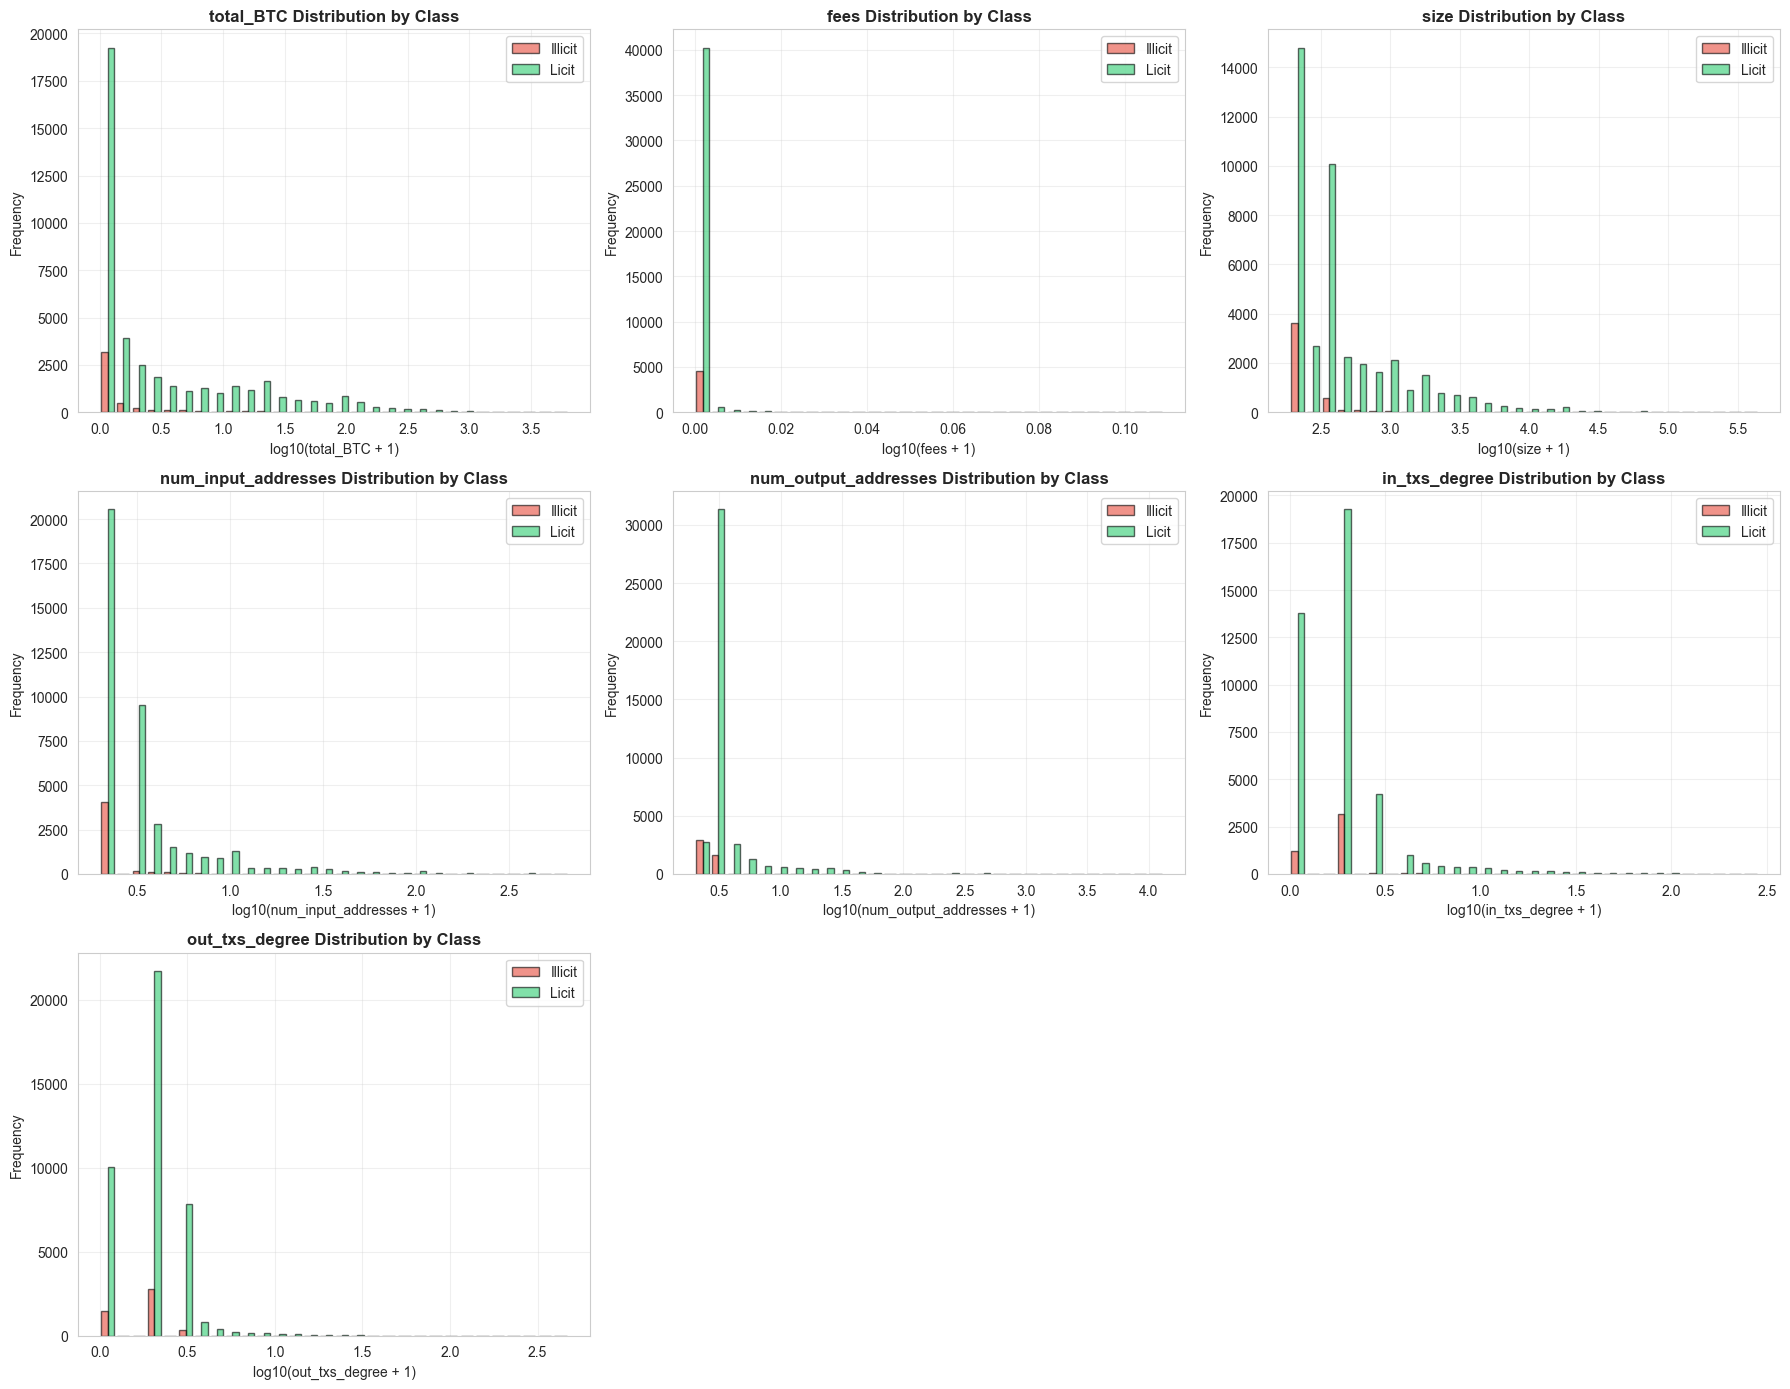

In [ ]:
# Compare features between illicit and licit transactions (NORMALIZED BY CLASS SIZE)
print("=== TRANSACTION FEATURES BY CLASS (NORMALIZED) ===")

# Filter out unknown class for comparison
txs_known = txs[txs['class_label'].isin(['Illicit', 'Licit'])].copy()

# Get class sizes for normalization
illicit_count = (txs_known['class_label'] == 'Illicit').sum()
licit_count = (txs_known['class_label'] == 'Licit').sum()
print(f"Illicit transactions: {illicit_count:,}")
print(f"Licit transactions: {licit_count:,}")
print(f"Ratio (Licit/Illicit): {licit_count/illicit_count:.2f}:1")

# Key features to compare
compare_features = ['total_BTC', 'fees', 'size', 'num_input_addresses', 
                   'num_output_addresses', 'in_txs_degree', 'out_txs_degree']

# Statistical comparison
for feature in compare_features:
    illicit_vals = txs_known[txs_known['class_label']=='Illicit'][feature].dropna()
    licit_vals = txs_known[txs_known['class_label']=='Licit'][feature].dropna()
    
    # Mann-Whitney U test (non-parametric)
    statistic, pvalue = stats.mannwhitneyu(illicit_vals, licit_vals, alternative='two-sided')
    
    print(f"\n{feature}:")
    print(f"  Illicit - Mean: {illicit_vals.mean():.6f}, Median: {illicit_vals.median():.6f}")
    print(f"  Licit   - Mean: {licit_vals.mean():.6f}, Median: {licit_vals.median():.6f}")
    print(f"  Mann-Whitney U test p-value: {pvalue:.4e}")

# Visualize distributions by class (NORMALIZED)
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for idx, feature in enumerate(compare_features[:9]):
    illicit_data = txs_known[txs_known['class_label']=='Illicit'][feature].dropna()
    licit_data = txs_known[txs_known['class_label']=='Licit'][feature].dropna()
    
    # Use log scale for better visualization
    if illicit_data.min() >= 0 and licit_data.min() >= 0:
        illicit_log = np.log10(illicit_data + 1)
        licit_log = np.log10(licit_data + 1)
        
        # Create normalized histograms (density=True)
        axes[idx].hist([illicit_log, licit_log], bins=30, label=['Illicit', 'Licit'],
                      color=['#e74c3c', '#2ecc71'], alpha=0.6, edgecolor='black',
                      density=True)  # NORMALIZED!
        axes[idx].set_xlabel(f'log10({feature} + 1)')
        axes[idx].set_ylabel('Density (Normalized)')
    else:
        axes[idx].hist([illicit_data, licit_data], bins=30, label=['Illicit', 'Licit'],
                      color=['#e74c3c', '#2ecc71'], alpha=0.6, edgecolor='black',
                      density=True)  # NORMALIZED!
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Density (Normalized)')
    
    axes[idx].set_title(f'{feature} Distribution by Class (Normalized)', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Remove extra subplots
for idx in range(len(compare_features), 9):
    fig.delaxes(axes[idx])

plt.suptitle('Feature Distributions Normalized by Class Size - Shows Trends Independent of Class Imbalance', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 10. Network Graph Analysis

=== TRANSACTION NETWORK ANALYSIS ===
Total edges in transaction graph: 234,355
Unique source nodes: 166,345
Unique target nodes: 148,447

=== GRAPH STATISTICS (sample of 10,000 edges) ===
Number of nodes: 17,957
Number of edges: 10,000
Is directed: True
Number of connected components: 7958

=== DEGREE STATISTICS ===
Average degree: 1.11
Average in-degree: 0.56
Average out-degree: 0.56
Max in-degree: 21
Max out-degree: 16


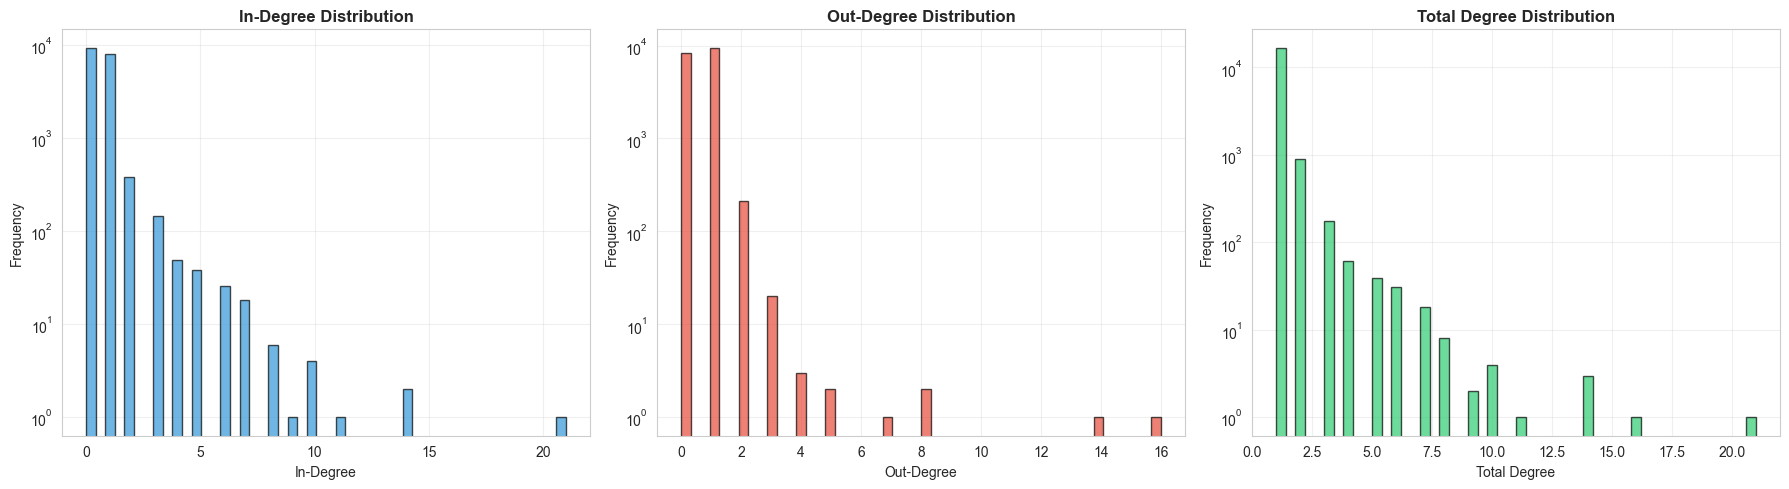


=== CLASS DISTRIBUTION IN NETWORK ===
Unknown → Unknown    5619
Unknown → Licit      1928
Licit → Licit        1454
Licit → Unknown       652
Unknown → Illicit     183
Illicit → Unknown      63
Illicit → Illicit      38
Illicit → Licit        33
Licit → Illicit        30
Name: count, dtype: int64


In [10]:
# Network analysis of transaction graph
print("=== TRANSACTION NETWORK ANALYSIS ===")
print(f"Total edges in transaction graph: {len(txs_edges):,}")
print(f"Unique source nodes: {txs_edges['txId1'].nunique():,}")
print(f"Unique target nodes: {txs_edges['txId2'].nunique():,}")

# Create network graph (sample for computational efficiency)
sample_size = min(10000, len(txs_edges))
edges_sample = txs_edges.sample(n=sample_size, random_state=42)

G = nx.DiGraph()
G.add_edges_from(edges_sample.values)

print(f"\n=== GRAPH STATISTICS (sample of {sample_size:,} edges) ===")
print(f"Number of nodes: {G.number_of_nodes():,}")
print(f"Number of edges: {G.number_of_edges():,}")
print(f"Is directed: {G.is_directed()}")
print(f"Number of connected components: {nx.number_weakly_connected_components(G)}")

# Degree statistics
degrees = dict(G.degree())
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

print(f"\n=== DEGREE STATISTICS ===")
print(f"Average degree: {np.mean(list(degrees.values())):.2f}")
print(f"Average in-degree: {np.mean(list(in_degrees.values())):.2f}")
print(f"Average out-degree: {np.mean(list(out_degrees.values())):.2f}")
print(f"Max in-degree: {max(in_degrees.values())}")
print(f"Max out-degree: {max(out_degrees.values())}")

# Visualize degree distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# In-degree distribution
in_deg_vals = list(in_degrees.values())
axes[0].hist(in_deg_vals, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('In-Degree')
axes[0].set_ylabel('Frequency')
axes[0].set_title('In-Degree Distribution', fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Out-degree distribution
out_deg_vals = list(out_degrees.values())
axes[1].hist(out_deg_vals, bins=50, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Out-Degree')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Out-Degree Distribution', fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

# Total degree distribution
deg_vals = list(degrees.values())
axes[2].hist(deg_vals, bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Total Degree')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Total Degree Distribution', fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze class distribution in graph
print("\n=== CLASS DISTRIBUTION IN NETWORK ===")
tx_id_to_class = dict(zip(txs['txId'], txs['class_label']))

# Count edges by class
edge_classes = []
for source, target in G.edges():
    source_class = tx_id_to_class.get(source, 'Unknown')
    target_class = tx_id_to_class.get(target, 'Unknown')
    edge_classes.append(f"{source_class} → {target_class}")

edge_class_counts = pd.Series(edge_classes).value_counts()
print(edge_class_counts)

## 11. Advanced Statistical Analysis

=== OUTLIER ANALYSIS ===

total_BTC:
  Outliers: 35,265 (17.31%)
  Bounds: [-9.7054, 16.3686]

fees:
  Outliers: 16,731 (8.21%)
  Bounds: [-0.0006, 0.0013]

size:
  Outliers: 25,571 (12.55%)
  Bounds: [3.0000, 595.0000]

num_input_addresses:
  Outliers: 49,616 (24.35%)
  Bounds: [1.0000, 1.0000]

num_output_addresses:
  Outliers: 40,260 (19.76%)
  Bounds: [2.0000, 2.0000]

=== DISTRIBUTION SHAPE ANALYSIS ===

total_BTC:
  Skewness: 26.7210 (right-skewed)
  Kurtosis: 1185.9181 (heavy-tailed)

fees:
  Skewness: 21.4721 (right-skewed)
  Kurtosis: 772.9635 (heavy-tailed)

size:
  Skewness: 38.8613 (right-skewed)
  Kurtosis: 3754.8781 (heavy-tailed)

num_input_addresses:
  Skewness: 24.8172 (right-skewed)
  Kurtosis: 811.0025 (heavy-tailed)

num_output_addresses:
  Skewness: 122.1691 (right-skewed)
  Kurtosis: 25128.4650 (heavy-tailed)

num_output_addresses:
  Outliers: 40,260 (19.76%)
  Bounds: [2.0000, 2.0000]

=== DISTRIBUTION SHAPE ANALYSIS ===

total_BTC:
  Skewness: 26.7210 (right-ske

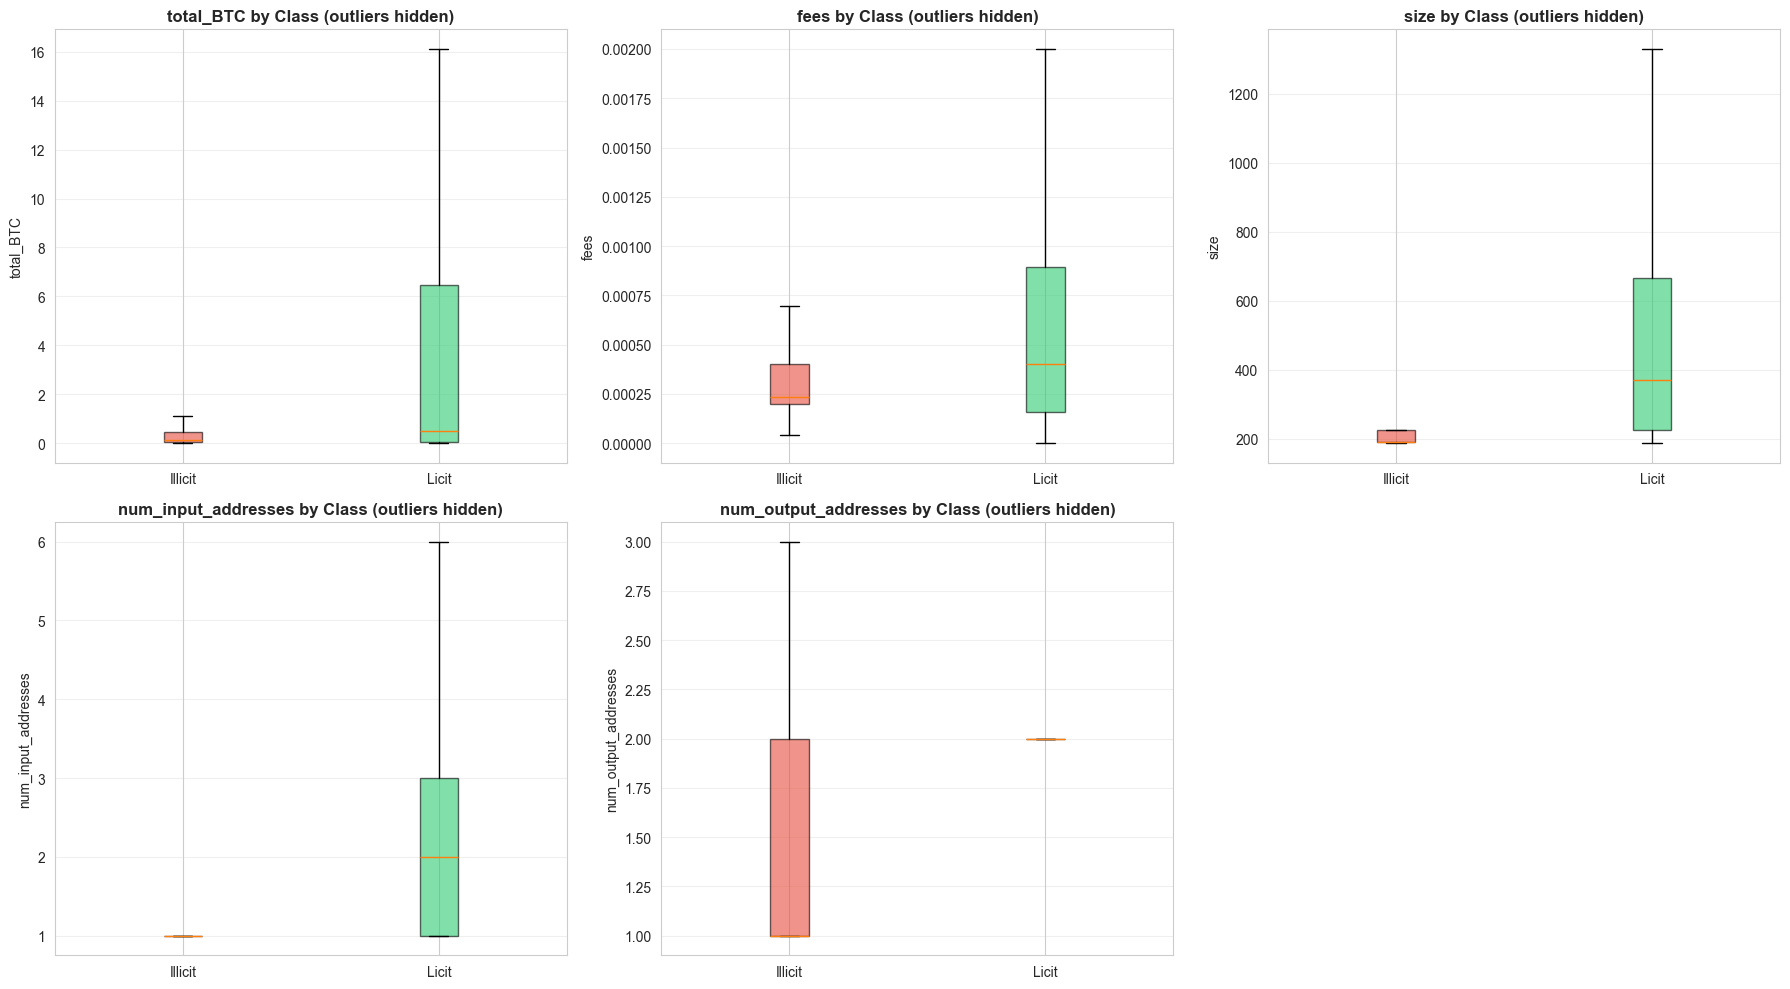

In [11]:
# Outlier detection and statistical tests
print("=== OUTLIER ANALYSIS ===")

# Detect outliers using IQR method for key features
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

outlier_features = ['total_BTC', 'fees', 'size', 'num_input_addresses', 'num_output_addresses']

for feature in outlier_features:
    n_outliers, lower, upper = detect_outliers_iqr(txs, feature)
    print(f"\n{feature}:")
    print(f"  Outliers: {n_outliers:,} ({n_outliers/len(txs)*100:.2f}%)")
    print(f"  Bounds: [{lower:.4f}, {upper:.4f}]")

# Skewness and kurtosis analysis
print("\n=== DISTRIBUTION SHAPE ANALYSIS ===")
for feature in outlier_features:
    data = txs[feature].dropna()
    skewness = stats.skew(data)
    kurt = stats.kurtosis(data)
    print(f"\n{feature}:")
    print(f"  Skewness: {skewness:.4f} {'(right-skewed)' if skewness > 0 else '(left-skewed)'}")
    print(f"  Kurtosis: {kurt:.4f} {'(heavy-tailed)' if kurt > 0 else '(light-tailed)'}")

# Visualize outliers with box plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(outlier_features):
    if idx < 6:
        data_to_plot = [
            txs_known[txs_known['class_label']=='Illicit'][feature].dropna(),
            txs_known[txs_known['class_label']=='Licit'][feature].dropna()
        ]
        
        bp = axes[idx].boxplot(data_to_plot, labels=['Illicit', 'Licit'],
                               patch_artist=True, showfliers=False)
        
        for patch, color in zip(bp['boxes'], ['#e74c3c', '#2ecc71']):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        
        axes[idx].set_ylabel(feature)
        axes[idx].set_title(f'{feature} by Class (outliers hidden)', fontweight='bold')
        axes[idx].grid(True, alpha=0.3, axis='y')

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

## 12. Feature Importance Analysis (Local & Aggregate Features)

### Understanding Correlation and Colors

**What is Correlation?**
- Correlation measures the relationship between two variables (ranges from -1 to +1)
- **Positive correlation** (green bars): When feature value increases, class value tends to increase
  - Example: Higher values of this feature are associated with higher class numbers (Licit=2)
- **Negative correlation** (red bars): When feature value increases, class value tends to decrease
  - Example: Higher values of this feature are associated with lower class numbers (Illicit=1)
- **Zero correlation**: No linear relationship between feature and class

**For our binary classification (Illicit=1 vs Licit=2):**
- **Green (positive correlation)**: Feature values tend to be higher for Licit transactions
- **Red (negative correlation)**: Feature values tend to be higher for Illicit transactions
- The **magnitude** (distance from zero) indicates the strength of the relationship

=== LOCAL FEATURES CORRELATION WITH CLASS ===
Total Local Features: 93
Total Aggregate Features: 72

=== TOP 20 LOCAL FEATURES CORRELATED WITH CLASS ===
Local_feature_53    0.261472
Local_feature_89    0.227629
Local_feature_55    0.227146
Local_feature_90    0.221294
Local_feature_91    0.185804
Local_feature_52    0.171799
Local_feature_54    0.142125
Local_feature_83    0.123440
Local_feature_85    0.119078
Local_feature_77    0.117977
Local_feature_84    0.117427
Local_feature_59    0.114065
Local_feature_65    0.114057
Local_feature_79    0.112552
Local_feature_78    0.111299
Local_feature_74    0.108698
Local_feature_75    0.108100
Local_feature_47    0.106856
Local_feature_60    0.105803
Local_feature_66    0.105796
Name: class, dtype: float64

=== TOP 20 AGGREGATE FEATURES CORRELATED WITH CLASS ===
Aggregate_feature_49    0.191936
Aggregate_feature_57    0.187232
Aggregate_feature_61    0.152966
Aggregate_feature_21    0.137636
Aggregate_feature_55    0.135878
Aggregate_feature

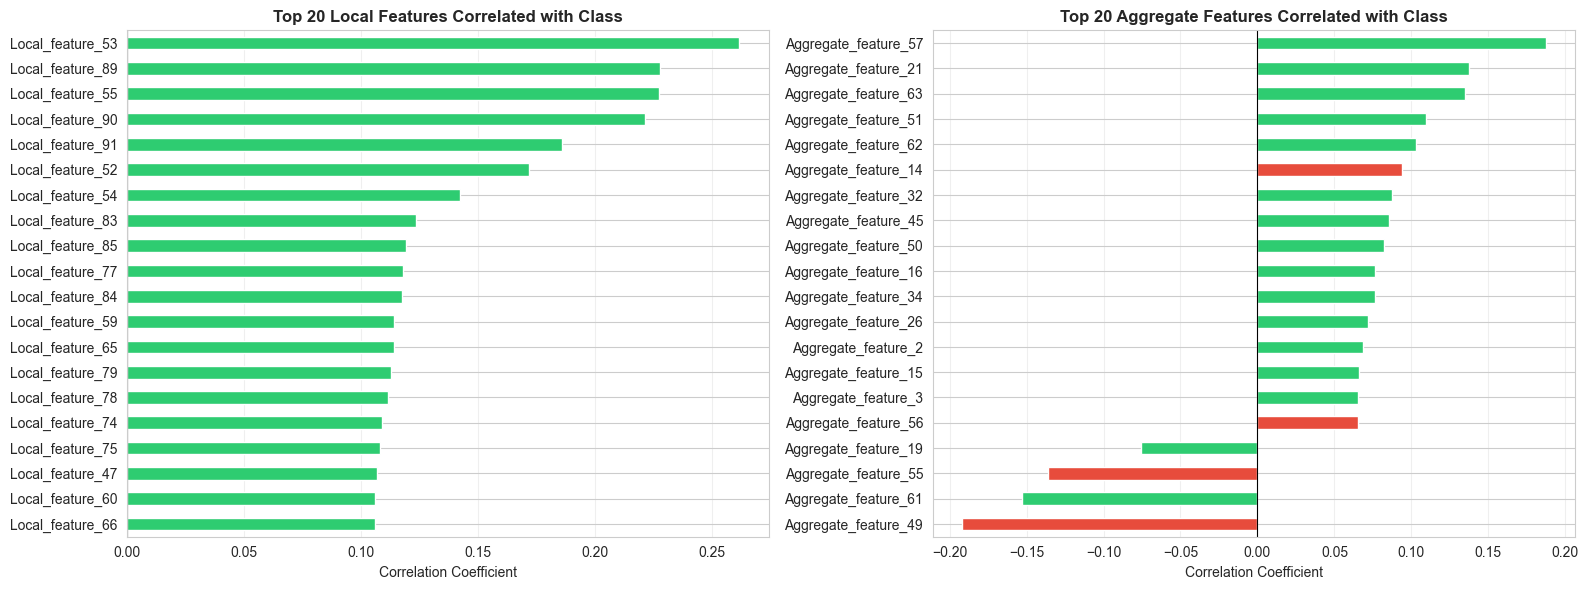


=== FEATURE TYPE STATISTICS ===
Local features - Mean |correlation|: 0.0670
Local features - Max |correlation|: 0.2615
Aggregate features - Mean |correlation|: 0.0470
Aggregate features - Max |correlation|: 0.1919


In [12]:
# Analyze Local and Aggregate features correlation with class
print("=== LOCAL FEATURES CORRELATION WITH CLASS ===")

# Get local features
local_cols = [c for c in txs.columns if c.startswith("Local_feature_")]
aggregate_cols = [c for c in txs.columns if c.startswith("Aggregate_feature_")]

print(f"Total Local Features: {len(local_cols)}")
print(f"Total Aggregate Features: {len(aggregate_cols)}")

# Calculate correlations with class (only for known classes)
txs_known_numeric = txs_known[local_cols + aggregate_cols + ['class']].dropna()

local_corr = txs_known_numeric[local_cols + ['class']].corr()['class'].drop('class')
aggregate_corr = txs_known_numeric[aggregate_cols + ['class']].corr()['class'].drop('class')

# Top correlated features
print("\n=== TOP 20 LOCAL FEATURES CORRELATED WITH CLASS ===")
top_local = local_corr.abs().sort_values(ascending=False).head(20)
print(top_local)

print("\n=== TOP 20 AGGREGATE FEATURES CORRELATED WITH CLASS ===")
top_aggregate = aggregate_corr.abs().sort_values(ascending=False).head(20)
print(top_aggregate)

# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Local features
top_local_signed = local_corr.loc[top_local.index]
colors_local = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_local_signed]
top_local_signed.sort_values().plot(kind='barh', ax=axes[0], color=colors_local)
axes[0].set_title('Top 20 Local Features Correlated with Class', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Correlation Coefficient')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[0].grid(True, alpha=0.3, axis='x')

# Aggregate features
top_aggregate_signed = aggregate_corr.loc[top_aggregate.index]
colors_agg = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_aggregate_signed]
top_aggregate_signed.sort_values().plot(kind='barh', ax=axes[1], color=colors_agg)
axes[1].set_title('Top 20 Aggregate Features Correlated with Class', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Correlation Coefficient')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Summary statistics of feature types
print("\n=== FEATURE TYPE STATISTICS ===")
print(f"Local features - Mean |correlation|: {local_corr.abs().mean():.4f}")
print(f"Local features - Max |correlation|: {local_corr.abs().max():.4f}")
print(f"Aggregate features - Mean |correlation|: {aggregate_corr.abs().mean():.4f}")
print(f"Aggregate features - Max |correlation|: {aggregate_corr.abs().max():.4f}")

In [ ]:
# Analyze wallet features correlation with class
print("=== WALLET FEATURES CORRELATION WITH CLASS ===")

# Get wallet features (exclude non-feature columns)
exclude_cols = ['address', 'class', 'class_label', 'Time step']
wallet_feature_cols = [c for c in wallets.columns if c not in exclude_cols and wallets[c].dtype != 'object']

print(f"Total Wallet Features: {len(wallet_feature_cols)}")

# Calculate correlations with class (only for known classes)
wallets_known = wallets[wallets['class_label'].isin(['Illicit', 'Licit'])].copy()
wallets_known_numeric = wallets_known[wallet_feature_cols + ['class']].dropna()

wallet_feature_corr = wallets_known_numeric[wallet_feature_cols + ['class']].corr()['class'].drop('class')

# Top correlated features
print("\n=== TOP 30 WALLET FEATURES CORRELATED WITH CLASS ===")
top_wallet_features = wallet_feature_corr.abs().sort_values(ascending=False).head(30)
print(top_wallet_features)

# Visualize top features
fig, axes = plt.subplots(1, 1, figsize=(14, 10))

# Wallet features with meaningful names
top_wallet_signed = wallet_feature_corr.loc[top_wallet_features.index]
colors_wallet = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_wallet_signed]
top_wallet_signed.sort_values().plot(kind='barh', ax=axes, color=colors_wallet, edgecolor='black')
axes.set_title('Top 30 Wallet Features Correlated with Class', fontweight='bold', fontsize=14)
axes.set_xlabel('Correlation Coefficient', fontsize=12)
axes.set_ylabel('Feature Name', fontsize=12)
axes.axvline(x=0, color='black', linestyle='-', linewidth=1.2)
axes.grid(True, alpha=0.3, axis='x')

# Add text annotations for strongest correlations
for i, (feature, value) in enumerate(top_wallet_signed.sort_values().items()):
    if abs(value) > 0.05:  # Only annotate stronger correlations
        axes.text(value + 0.002 if value > 0 else value - 0.002, i, 
                 f'{value:.3f}', va='center', ha='left' if value > 0 else 'right',
                 fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== WALLET FEATURE CORRELATION STATISTICS ===")
print(f"Mean |correlation|: {wallet_feature_corr.abs().mean():.4f}")
print(f"Max |correlation|: {wallet_feature_corr.abs().max():.4f}")
print(f"Features with |correlation| > 0.1: {(wallet_feature_corr.abs() > 0.1).sum()}")
print(f"Features with |correlation| > 0.05: {(wallet_feature_corr.abs() > 0.05).sum()}")

# Group by feature categories
print("\n=== CORRELATION BY FEATURE CATEGORY ===")
categories = {
    'Transaction Count': ['num_txs_as_sender', 'num_txs_as receiver', 'total_txs'],
    'Temporal': ['lifetime_in_blocks', 'num_timesteps_appeared_in', 'first_block_appeared_in', 
                 'last_block_appeared_in', 'first_sent_block', 'first_received_block'],
    'BTC Amount': [c for c in wallet_feature_cols if 'btc_' in c.lower()],
    'Fees': [c for c in wallet_feature_cols if 'fees' in c.lower()],
    'Block Intervals': [c for c in wallet_feature_cols if 'blocks_btwn' in c.lower()],
    'Address Interactions': [c for c in wallet_feature_cols if 'addr' in c.lower() or 'transacted_w' in c.lower()]
}

for category, features in categories.items():
    available_features = [f for f in features if f in wallet_feature_corr.index]
    if available_features:
        avg_corr = wallet_feature_corr[available_features].abs().mean()
        max_corr = wallet_feature_corr[available_features].abs().max()
        print(f"\n{category}:")
        print(f"  Features: {len(available_features)}")
        print(f"  Avg |correlation|: {avg_corr:.4f}")
        print(f"  Max |correlation|: {max_corr:.4f}")

### Understanding Correlation for Wallet Features

Same interpretation as transaction features:
- **Green bars (positive)**: Higher values → more likely Licit wallets
- **Red bars (negative)**: Higher values → more likely Illicit wallets
- Wallet features have actual meaningful names (not generic like "Local_feature_X")

## 13. Wallet Feature Importance Analysis (Named Features)